In [39]:
import os
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pandas as pd

In [40]:
plt.style.use("seaborn-whitegrid")
rcParams = matplotlib.rcParams

## Functions

In [41]:
def get_metrics(model_name, dataset_name):
    metric_files = []
    directories = os.listdir("results/"+dataset_name+"/"+model_name)
    for exp_id in directories:
        if exp_id != ".DS_Store":
            filepath = "results/"+dataset_name+"/"+model_name + "/" +exp_id +"/metrics.pckl"
            with open(filepath, "rb") as file:
                metric_file = pickle.load(file)
                metric_files.append(metric_file)
        
    final_metrics = dict()
    for key in metric_files[0].keys():
        final_metrics[key] = [metric[key] for metric in metric_files]
    return final_metrics
    

In [42]:
def get_metrics_avg(model_name, dataset_name):
    metrics = get_metrics(model_name, dataset_name)
    for key in metrics.keys():
        metrics[key] = np.mean(metrics[key])
    return metrics

In [43]:
def get_all_metrics_avg(model_name, datasets):
    final_metrics = dict()
    keys = get_metrics_avg(model_name, datasets[0]).keys()
    for key in keys:
        final_metrics[key] = [get_metrics_avg(model_name, dataset)[key] for dataset in datasets]
    return final_metrics    

In [44]:
def small_datasets():
    all_datasets = os.listdir("results/")
    return list(filter(lambda x: x!= ".DS_Store" and x[0:3]!= "cd_", all_datasets))

In [45]:
def cd_datasets():
    all_datasets = os.listdir("results/")
    return list(filter(lambda x: x!= ".DS_Store" and x[0:3]== "cd_", all_datasets))

In [10]:
cd_datasets()

['cd_friedman1_global_abrupt', 'cd_airlines_700k']

## Small-data scatterplots

In [19]:
def small_scatterplot():
    large_text = 16
    small_text = 14
    fig_width = 9
    fig_height = 6
    params = {
      'axes.labelsize': large_text,
      'font.size': small_text,
      'legend.fontsize': small_text,
      'xtick.labelsize': small_text,
      'ytick.labelsize': small_text,
      'text.usetex': True,
      'figure.figsize': [fig_width, fig_height]
    }
    rcParams.update(params)


    markers = itertools.cycle(('o', '^', 's', 'x', '*', 'D', 'J'))
    for method in ["MondrianForest", "OnlineQRF", "CPApprox", "CPExact"]:
        method_metrics = get_all_metrics_avg(method, small_datasets())
        x,y = method_metrics["MER"], method_metrics["RIS"]
        plt.scatter(x,y, marker=next(markers), label = method)  # Can use util or ris on the y axis

    plt.legend()
    plt.xlabel("MER")
    plt.ylabel("RIS")
    plt.ylim(ymax=1.05, ymin=-0.05)

    plt.axvline(x=0.1, linestyle='dashed', color='grey')
    plt.title("Small-scale Data RIS vs. MER")
    plt.savefig("Images/small-RIS-MER.pdf", bbox_inches = "tight")
    plt.show()

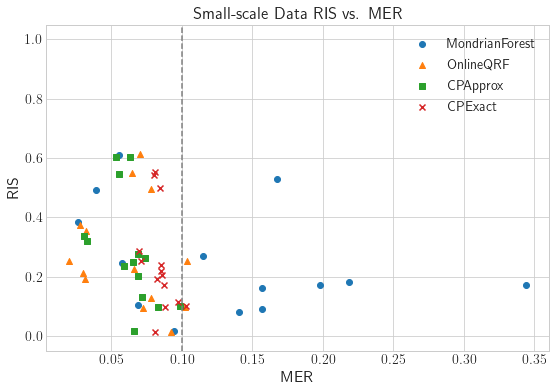

In [20]:
small_scatterplot()

## Small-data violin plot

In [21]:
def violin_plot(metric):
    # Note metrics is either Utility or QL
    large_text = 16
    small_text = 14
    params = {
        'axes.labelsize': large_text,
        'font.size': small_text,
        'legend.fontsize': small_text,
        'xtick.labelsize': small_text,
        'ytick.labelsize': small_text,
        'text.usetex': True,
        'figure.figsize': [9, 6]
    }
    rcParams.update(params)

    y_label = "Quantile Loss" if metric == "QL" else "Utility"
    
    
    dat = {method:get_all_metrics_avg(method, small_datasets())[metric] for method in ["MondrianForest","CPExact", "CPApprox", "OnlineQRF"]}
    pd_dat = pd.DataFrame(dat)
    sns.violinplot(data = pd_dat, cut=0, inner=None, bw=0.4, scale="width")
    
    ax = sns.violinplot( data=pd_dat, cut=0, inner=None, bw=0.4,
                        scale="width")
    ax = sns.swarmplot( data=pd_dat, edgecolor="grey", color="black")

    ax.set_ylabel(y_label)

    plt.title("Method " + y_label + " on Small-Scale Data" )
    plt.savefig("Images/" + y_label + "-violin.pdf", bbox_inches = "tight")

    plt.show()



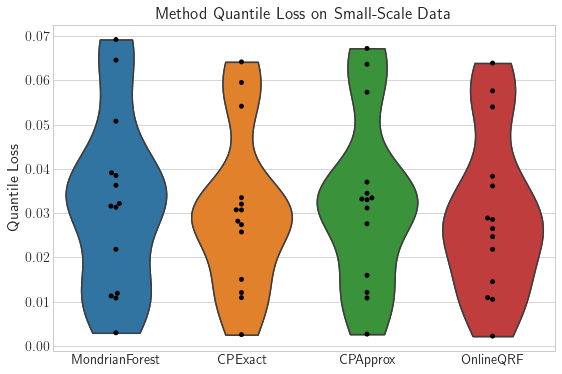

In [23]:
violin_plot("QL")

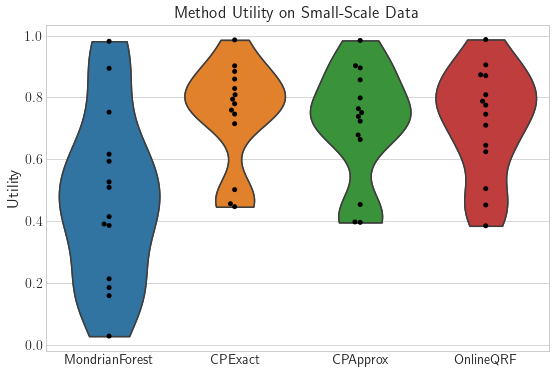

In [24]:
violin_plot("Utility")

## Concept drift tumbling-metric plots

In [33]:
def plot_tumbling_metric(metric, dataset, dataset_name):
    marker = itertools.cycle(('o', '^', 's', 'x', '*', 'D', 'J'))
    for method in ["MondrianForest", "OnlineQRF","CPExact", "CPApprox"]:
        metric_array = get_metrics(method, dataset)[metric][0]
        x,y =  np.array(metric_array).T
        plt.plot(x,y, label=method, marker=next(marker), markevery=10000)
        plt.legend(loc = "best")
        plt.ylabel(metric)
        plt.xlabel("Training instances")
        plt.title(metric + " Performance on " +dataset_name)
        filename = "tumbling_plot_"+ metric + "_" +dataset
    plt.savefig("Images/"+ filename +".pdf", bbox_inches = "tight")
    plt.show()

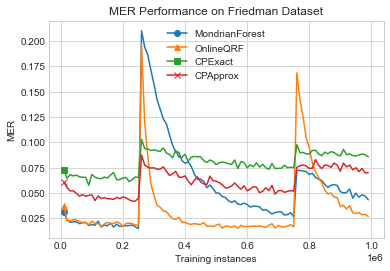

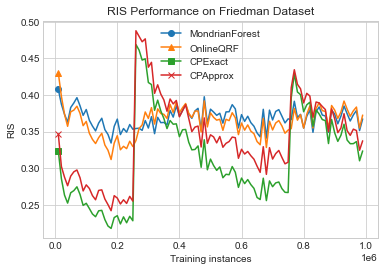

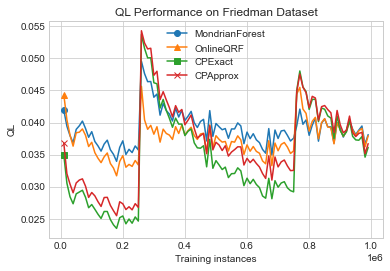

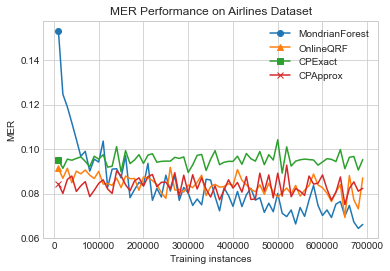

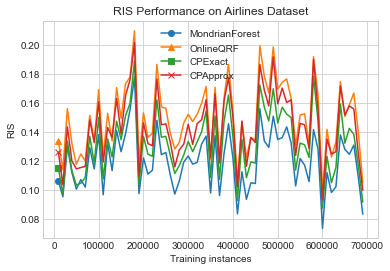

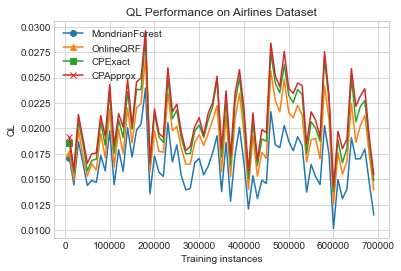

In [67]:
datasets_with_names = list(zip(cd_datasets(),["Friedman Dataset", "Airlines Dataset"]))
for dataset, name in datasets_with_names:
    for metric in ["MER", "RIS", "QL"]:
        plot_tumbling_metric(metric, dataset, name)

## Average runtime of methods on datasets

In [1]:
# Used to generate the tables in the runtime subsection of results section

In [64]:
def runtimes(datasets):
    methods = ["MondrianForest","CPExact", "CPApprox", "OnlineQRF"]
    small_data_times = {method: 0 for method in methods}
    for dataset in datasets:
        for method in methods:
            runtime = get_metrics_avg(method, dataset)["time"]/len(datasets)
            small_data_times[method] = small_data_times[method] + runtime
    return small_data_times

In [65]:
runtimes(small_datasets())

{'MondrianForest': 185.07801965000013,
 'CPExact': 74.02760498571467,
 'CPApprox': 49.68428196428605,
 'OnlineQRF': 49.01320334999987}

In [66]:
runtimes([cd_datasets()[0]])

{'MondrianForest': 9861.789,
 'CPExact': 9455.841429,
 'CPApprox': 6576.164228000001,
 'OnlineQRF': 6425.369162999999}